In [2]:
!kaggle competitions download -c playground-series-s4e1


  0%|          | 0.00/6.81M [00:00<?, ?B/s]
 15%|#4        | 1.00M/6.81M [00:01<00:09, 623kB/s]
 29%|##9       | 2.00M/6.81M [00:01<00:04, 1.24MB/s]
 44%|####4     | 3.00M/6.81M [00:02<00:02, 1.94MB/s]
 59%|#####8    | 4.00M/6.81M [00:02<00:01, 2.56MB/s]
 73%|#######3  | 5.00M/6.81M [00:02<00:00, 3.11MB/s]
 88%|########8 | 6.00M/6.81M [00:02<00:00, 3.46MB/s]
100%|##########| 6.81M/6.81M [00:02<00:00, 3.83MB/s]
100%|##########| 6.81M/6.81M [00:02<00:00, 2.43MB/s]


In [9]:
!mkdir data && tar -xf playground-series-s4e1.zip -C data

In [2]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/sample_submission.csv
data/test.csv
data/train.csv


In [3]:
trainingData = pd.read_csv("data/train.csv")

trainingData.drop(['Surname', 'id', 'CustomerId'], axis=1, inplace=True)
trainingData['Gender'] = trainingData['Gender'].map({'Male': 0, 'Female': 1})
trainingData['Geography'] = trainingData['Geography'].map({'France': 0, 'Spain': 1, 'Germany': 2})
trainingData.fillna(0, inplace=True)

X = trainingData.drop('Exited', axis=1).values
y = trainingData['Exited'].values

In [5]:
import torch

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
#STANDARDIZATION (Disable later and check how it affects accuracy)
X = (X - torch.mean(X, dim=0)) / torch.std(X, dim=0)

X = X.to("cpu")
y = y.to("cpu")

C:\Users\user\AppData\Local\Temp\ipykernel_5348\1563173207.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
C:\Users\user\AppData\Local\Temp\ipykernel_5348\1563173207.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)


In [123]:
import torch.nn as nn

class Classifier(nn.Module):
    def __init__(self, featureWeights):
        super().__init__()
        self.featureWeights = featureWeights

        self.weights = nn.Parameter(torch.tensor(featureWeights, dtype=torch.float32))
        self.layer1 = nn.Linear(10, 64)
        self.act1 = nn.LeakyReLU()
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.layer2 = nn.Linear(64, 32)
        self.act2 = nn.LeakyReLU()
        self.batchnorm2 = nn.BatchNorm1d(32)
        self.layer3 = nn.Linear(32, 1)
        self.act3 = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x * self.weights
        x = self.act1(self.layer1(x))
        x = self.batchnorm1(x)
        x = self.act2(self.layer2(x))
        x = self.batchnorm2(x)
        x = self.act3(self.layer3(x))
        x = self.sigmoid(x)
        x = self.dropout(x)
        return x

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier()
rf_classifier.fit(X, y)

RandomForestClassifier()

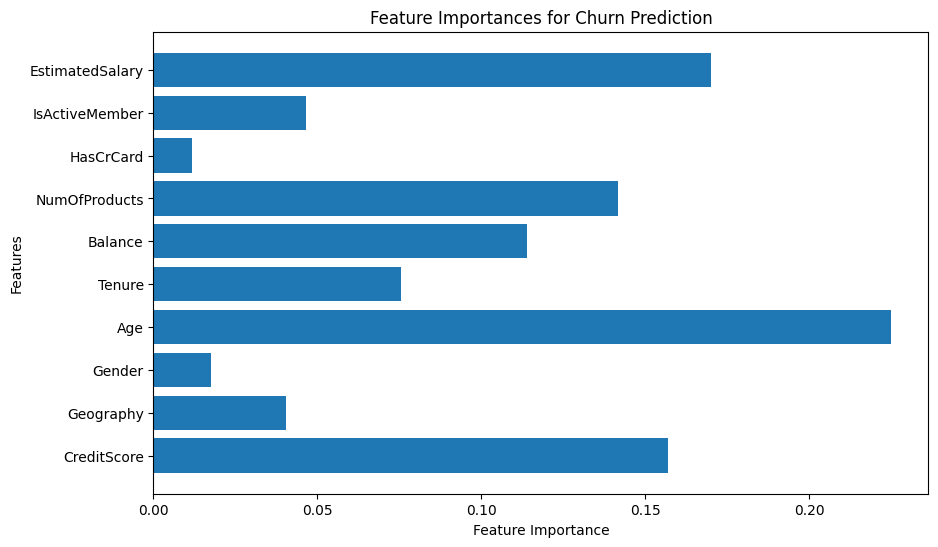

In [26]:
feature_importances = rf_classifier.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(['CreditScore','Geography','Gender','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary'], feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importances for Churn Prediction')
plt.show()

In [107]:
import torch.optim as optim

model = Classifier(feature_importances).to("cpu")
lossFN = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch [1/10], Loss: 0.6629, Accuracy: 0.8810
Epoch [2/10], Loss: 0.6714, Accuracy: 0.8571
Epoch [3/10], Loss: 0.6476, Accuracy: 0.9048
Epoch [4/10], Loss: 0.6586, Accuracy: 0.8095
Epoch [5/10], Loss: 0.6576, Accuracy: 0.9286
Epoch [6/10], Loss: 0.6544, Accuracy: 0.8095
Epoch [7/10], Loss: 0.6328, Accuracy: 0.8571
Epoch [8/10], Loss: 0.6885, Accuracy: 0.8810
Epoch [9/10], Loss: 0.6447, Accuracy: 0.9048
Epoch [10/10], Loss: 0.6529, Accuracy: 0.7619
Completed training in  27.771169424057007 s


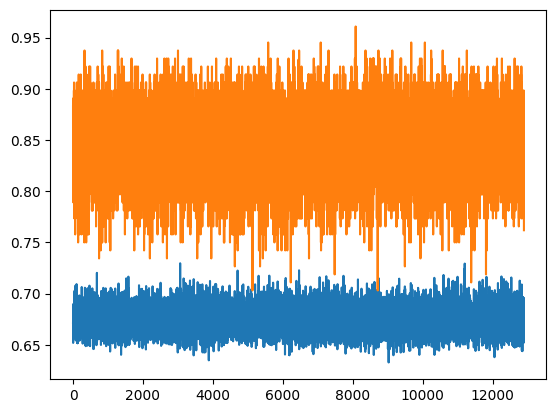

In [109]:
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import time

dataset = TensorDataset(X, y)
dataLoader = DataLoader(dataset, batch_size=128, shuffle=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

losses = []
accuracies = []
NUM_EPOCHS = 10

startTime = time.time()
for epoch in range(NUM_EPOCHS):
    model.train()
    for inputs, labels in dataLoader:
        optimizer.zero_grad()
        outputs = model(inputs)
        predicted_probabilities = outputs.squeeze(1)  # Remove the singleton dimension
        predicted_labels = (predicted_probabilities >= 0.5).float()  # Convert probabilities to binary predictions
        accuracy = (predicted_labels == labels).float().mean()
        
        loss = lossFN(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        accuracies.append(accuracy.item())

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item():.4f}, Accuracy: {accuracy.item():.4f}')

print("Completed training in ", time.time() - startTime, "s")
plt.plot(losses)
plt.plot(accuracies)
plt.show()

In [110]:
y[15:25]

tensor([0., 0., 0., 1., 1., 0., 0., 0., 1., 0.])

In [157]:
#Checking the model
model.eval()
output = model(X[0:-1])

predicts = torch.round(output.squeeze(1) * 10) / 10
# predict = (predict >= 0.5).int().reshape(-1)
output.data.squeeze(1)

tensor([1.2773e-04, 1.8140e-04, 4.0286e-04,  ..., 3.0933e-04, 1.2848e-04,
        6.5833e-05])

In [134]:
import torch

# Create a random float tensor
tensor = torch.rand((3, 3))

# Round the tensor to 2 decimal places
rounded_tensor = torch.round(tensor * 10 ** 2) / (10 ** 2)
rounded_tensor

tensor([[0.2700, 0.0300, 0.4800],
        [0.4400, 0.4300, 0.7400],
        [0.5400, 0.1800, 0.1800]])

In [161]:
#Test Set
testData = pd.read_csv("data/test.csv")

y_test = testData['id']
testData.drop(['Surname', 'id', 'CustomerId'], axis=1, inplace=True)
testData['Gender'] = trainingData['Gender'].map({'Male': 0, 'Female': 1})
testData['Geography'] = trainingData['Geography'].map({'France': 0, 'Spain': 1, 'Germany': 2})
testData.fillna(0, inplace=True)

In [171]:
y_test.values

array([165034, 165035, 165036, ..., 275054, 275055, 275056], dtype=int64)

In [166]:
X_test = testData.values
X_test = torch.tensor(X_test, dtype=torch.float32)
#STANDARDIZATION (Disable later and check how it affects accuracy)
X_test = (X_test - torch.mean(X_test, dim=0)) / torch.std(X_test, dim=0)
X_test = X_test.to("cpu")

In [168]:
predictions = []
model.eval()
with torch.no_grad():
    for inputs in X_test:
        outputs = model(inputs)
        predicted = torch.round(output.squeeze(1) * 10) / 10
        predictions.extend(predicted.cpu().numpy())

ValueError: expected 2D or 3D input (got 1D input)